# Compute PMF of dialanine dihedrals with umbrella sampling and FastMBAR

In [13]:
## import required packages
import os, math, sys
import numpy as np
import matplotlib.pyplot as plt
import simtk.openmm.app  as omm_app
import simtk.openmm as omm
import simtk.unit as unit
from tqdm import tqdm
import mdtraj
from FastMBAR import *

**NOTE:** The following commands use relative directory pathees and assume that the current working directory is FastMBAR/examples/dialanine. Therefore, the current working directory has to be changed into FastMBAR/examples/dialanine before running the following commands.

In [2]:
## change the working directory into ./examples/butane
os.chdir("../")
print("current working directory: {}".format(os.getcwd()))
assert os.getcwd()[-10:] == "/dialanine", ( 
       f"Error: your current working directory is {os.getcwd()}!"
        "You need to change working directory to ./examples/dialanine."
       )

current working directory: /Users/dingxq/Google Drive/ProjectsOnGitHub/FastMBAR/examples/dialanine


## 1. Construct an OpenMM system of butane
Because we are using OpenMM as our MD engine, we need to setup the
MD molecular system in the format required by OpenMM. The format/object
used by OpenMM for a molecular system happens to be a class called [System](http://docs.openmm.org/latest/api-python/generated/simtk.openmm.openmm.System.html#simtk.openmm.openmm.System).
Therefore, we will prepare our MD molecular system as an OpenMM System.
When we prepare the OpenMM system, we add a [CustomTorsionForce](http://docs.openmm.org/latest/api-python/generated/simtk.openmm.openmm.CustomTorsionForce.html#simtk.openmm.openmm.CustomTorsionForce) so
that we can add biasing potentials to the system in the following umbrella
sampling.

Read **psf** and **pdb** files of dialanine: dialanine.psf and dialanine.pdb.
The psf file, dialanine.psf, contains topolgy of butane and it is the topolgy file format used by CHARMM.
The psf file, dialanine.psf, used here is generated using CHARMM.
In your study, you usually alreay have a pdb file of your system. 
You can generate the topology file of your system using various MD softwares such as CHARMM, Gromacs and Amber among others. Just note that different softwares use different format for topology files and OpenMM has 
several parser for topology files with different foramt.

In [14]:
psf = omm_app.CharmmPsfFile('./data/dialanine.psf')
pdb = omm_app.PDBFile('./data/dialanine.pdb')

Read CHARMM force field for dialanine. The CHARMM force field is downloaded from [here](http://mackerell.umaryland.edu/charmm_ff.shtml)

In [15]:
charmm_toppar = omm_app.CharmmParameterSet("./data/top_all36_prot.rtf",
                                           "./data/par_all36_prot.prm")

Create a OpenMM system based on the psf file of dialanine and the CHARMM force field.
Then two harmonic biasing potentials are added to the system for dihedral $\psi$ (4-6-8-14) and dihedral $\phi$ (6-8-14,16) so that we can use biasing potentials in the following umbrella sampling.
Adding biasing potentials to torsions of a system is very easy in OpenMM. 
We don't have to change any source code of OpenMM. All we need to do is to tell OpenMM the formula of the biasing potential and degree of freedom we want to add biasing potentials to.

In [16]:
## create a OpenMM system based on psf of dialanine and CHARMM force field
system = psf.createSystem(charmm_toppar, nonbondedMethod = omm_app.NoCutoff)

## add harmonic biasing potentials on two dihedrals of dialanine (psi, phi) in the OpenMM system
## for dihedral psi
bias_torsion_psi = omm.CustomTorsionForce("0.5*k_psi*dtheta^2; dtheta = min(tmp, 2*pi-tmp); tmp = abs(theta - psi)")
bias_torsion_psi.addGlobalParameter("pi", math.pi)
bias_torsion_psi.addGlobalParameter("k_psi", 1.0)
bias_torsion_psi.addGlobalParameter("psi", 0.0)
## 4, 6, 8, 14 are indices of the atoms of the torsion psi
bias_torsion_psi.addTorsion(4, 6, 8, 14)

## for dihedral phi
bias_torsion_phi = omm.CustomTorsionForce("0.5*k_phi*dtheta^2; dtheta = min(tmp, 2*pi-tmp); tmp = abs(theta - phi)")
bias_torsion_phi.addGlobalParameter("pi", math.pi)
bias_torsion_phi.addGlobalParameter("k_phi", 1.0)
bias_torsion_phi.addGlobalParameter("phi", 0.0)
## 6, 8, 14, 16 are indices of the atoms of the torsion phi
bias_torsion_phi.addTorsion(6, 8, 14, 16)

system.addForce(bias_torsion_psi)
system.addForce(bias_torsion_phi)

9

After constructing the OpenMM system of dialanine, we can save it in an XML formated text file, which can be used later for simulations. Therefore, if we want to use the same system in another script, we can just read the text file in an OpenMM system instead of constructing it again.
You can even open the XML formated text file using a text editor and see what information about the system is included in the XML file.

In [17]:
## save the OpenMM system of butane
with open("./output/system.xml", 'w') as file_handle:
    file_handle.write(omm.XmlSerializer.serialize(system))

## 2. Run umbrella sampling
We run umbrella sampling for two dianaline dihedrals: dihedral $\psi$ with atom indices of 4-6-8-14 and dihedral $\phi$ with atom indices of 6-8-14-16.
Both dihedrals are split into multiple windows and in each window, the two dihedrals
are restrainted around a center using a harmonic biasing potential. In this
script, we run simulations in each window sequentially, but they can be run in
parallel if you have a computer cluster with multiple nodes.

In [18]:
## read the OpenMM system of dialanine
with open("./output/system.xml", 'r') as file_handle:
    xml = file_handle.read()
system = omm.XmlSerializer.deserialize(xml)

## read psf and pdb file of dialanine
psf = omm_app.CharmmPsfFile("./data/dialanine.psf")
pdb = omm_app.PDBFile('./data/dialanine.pdb')

In order to run simulations in OpenMM, we need to construct an OpenMM context, which consists of a system, an integrator and a platform.
The system is just the dialanine system we have constructed above.
The integrator specifies what kind integration method we should use. Here, we will use Langevin dynamics for NVP ensemble simulation, which corresponds to the OpenMM.LangevinIntegrator.
The platform specifies what kind of hardware we will run simulation on. Here, we choose to use CPUs.

In [19]:
## setup an OpenMM context
platform = omm.Platform.getPlatformByName('CPU')
T = 298.15 * unit.kelvin
fricCoef = 10/unit.picoseconds
stepsize = 1 * unit.femtoseconds
integrator = omm.LangevinIntegrator(T, fricCoef, stepsize)
context = omm.Context(system, integrator, platform)

Here we set the force constant and centers for the harmonic biasing potentials on dialanine dihedral.

In [20]:
## set force constant K for the biasing potential. 
## the unit here is kJ*mol^{-1}*nm^{-2}, which is the default unit used in OpenMM
k_psi = 100
k_phi = 100
context.setParameter("k_psi", k_psi)
context.setParameter("k_phi", k_phi)

## equilibrium value for both psi and phi in biasing potentials
m = 25
M = m*m
psi = np.linspace(-math.pi, math.pi, m, endpoint = False)
phi = np.linspace(-math.pi, math.pi, m, endpoint = False)

The following loop is used to run umbrella sampling window by window.
In each iteration, we first set the centers of the two harmonic biasing potentials.
Then the configuration of dialanine is minimized and equilibrated with the biasing potentials.
After initial equilibration, configurations are sampled and saved.

In [12]:
## the main loop to run umbrella sampling window by window
for idx in range(M):
    psi_index = idx // m
    phi_index = idx % m

    print(f"sampling at psi index: {psi_index} out of {m}, phi index: {phi_index} out of {m}")

    ## set the center of the biasing potential
    context.setParameter("psi", psi[psi_index])
    context.setParameter("phi", phi[phi_index])

    ## minimize
    context.setPositions(pdb.positions)
    state = context.getState(getEnergy = True)
    energy = state.getPotentialEnergy()
    for i in range(50):
        omm.LocalEnergyMinimizer_minimize(context, 1, 20)
        state = context.getState(getEnergy = True)
        energy = state.getPotentialEnergy()

    ## initial equilibrium
    integrator.step(5000)

    ## sampling production. trajectories are saved in dcd files
    file_handle = open(f"./output/traj/traj_psi_{psi_index}_phi_{phi_index}.dcd", 'bw')
    dcd_file = omm_app.dcdfile.DCDFile(file_handle, psf.topology, dt = stepsize)
    for i in tqdm(range(100)):
        integrator.step(100)
        state = context.getState(getPositions = True)
        positions = state.getPositions()
        dcd_file.writeModel(positions)
    file_handle.close()

sampling at psi index: 0 out of 25, phi index: 0 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.67it/s]


sampling at psi index: 0 out of 25, phi index: 1 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.86it/s]


sampling at psi index: 0 out of 25, phi index: 2 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.31it/s]


sampling at psi index: 0 out of 25, phi index: 3 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.41it/s]


sampling at psi index: 0 out of 25, phi index: 4 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.23it/s]


sampling at psi index: 0 out of 25, phi index: 5 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.40it/s]


sampling at psi index: 0 out of 25, phi index: 6 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.21it/s]


sampling at psi index: 0 out of 25, phi index: 7 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.58it/s]


sampling at psi index: 0 out of 25, phi index: 8 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.27it/s]


sampling at psi index: 0 out of 25, phi index: 9 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.18it/s]


sampling at psi index: 0 out of 25, phi index: 10 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.71it/s]


sampling at psi index: 0 out of 25, phi index: 11 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.64it/s]


sampling at psi index: 0 out of 25, phi index: 12 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.28it/s]


sampling at psi index: 0 out of 25, phi index: 13 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.50it/s]


sampling at psi index: 0 out of 25, phi index: 14 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.25it/s]


sampling at psi index: 0 out of 25, phi index: 15 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.98it/s]


sampling at psi index: 0 out of 25, phi index: 16 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.41it/s]


sampling at psi index: 0 out of 25, phi index: 17 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.06it/s]


sampling at psi index: 0 out of 25, phi index: 18 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.51it/s]


sampling at psi index: 0 out of 25, phi index: 19 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.59it/s]


sampling at psi index: 0 out of 25, phi index: 20 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.94it/s]


sampling at psi index: 0 out of 25, phi index: 21 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.38it/s]


sampling at psi index: 0 out of 25, phi index: 22 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.33it/s]


sampling at psi index: 0 out of 25, phi index: 23 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.39it/s]


sampling at psi index: 0 out of 25, phi index: 24 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.42it/s]


sampling at psi index: 1 out of 25, phi index: 0 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.72it/s]


sampling at psi index: 1 out of 25, phi index: 1 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.40it/s]


sampling at psi index: 1 out of 25, phi index: 2 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.54it/s]


sampling at psi index: 1 out of 25, phi index: 3 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.19it/s]


sampling at psi index: 1 out of 25, phi index: 4 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.48it/s]


sampling at psi index: 1 out of 25, phi index: 5 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.62it/s]


sampling at psi index: 1 out of 25, phi index: 6 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.56it/s]


sampling at psi index: 1 out of 25, phi index: 7 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.05it/s]


sampling at psi index: 1 out of 25, phi index: 8 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.46it/s]


sampling at psi index: 1 out of 25, phi index: 9 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.37it/s]


sampling at psi index: 1 out of 25, phi index: 10 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.45it/s]


sampling at psi index: 1 out of 25, phi index: 11 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.06it/s]


sampling at psi index: 1 out of 25, phi index: 12 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.85it/s]


sampling at psi index: 1 out of 25, phi index: 13 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.70it/s]


sampling at psi index: 1 out of 25, phi index: 14 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.51it/s]


sampling at psi index: 1 out of 25, phi index: 15 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.35it/s]


sampling at psi index: 1 out of 25, phi index: 16 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.51it/s]


sampling at psi index: 1 out of 25, phi index: 17 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.43it/s]


sampling at psi index: 1 out of 25, phi index: 18 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.31it/s]


sampling at psi index: 1 out of 25, phi index: 19 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.35it/s]


sampling at psi index: 1 out of 25, phi index: 20 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.85it/s]


sampling at psi index: 1 out of 25, phi index: 21 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.43it/s]


sampling at psi index: 1 out of 25, phi index: 22 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.92it/s]


sampling at psi index: 1 out of 25, phi index: 23 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.88it/s]


sampling at psi index: 1 out of 25, phi index: 24 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.47it/s]


sampling at psi index: 2 out of 25, phi index: 0 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.92it/s]


sampling at psi index: 2 out of 25, phi index: 1 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.75it/s]


sampling at psi index: 2 out of 25, phi index: 2 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.21it/s]


sampling at psi index: 2 out of 25, phi index: 3 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.23it/s]


sampling at psi index: 2 out of 25, phi index: 4 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.76it/s]


sampling at psi index: 2 out of 25, phi index: 5 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.66it/s]


sampling at psi index: 2 out of 25, phi index: 6 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.32it/s]


sampling at psi index: 2 out of 25, phi index: 7 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.85it/s]


sampling at psi index: 2 out of 25, phi index: 8 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.49it/s]


sampling at psi index: 2 out of 25, phi index: 9 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.84it/s]


sampling at psi index: 2 out of 25, phi index: 10 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.38it/s]


sampling at psi index: 2 out of 25, phi index: 11 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.69it/s]


sampling at psi index: 2 out of 25, phi index: 12 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.43it/s]


sampling at psi index: 2 out of 25, phi index: 13 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.27it/s]


sampling at psi index: 2 out of 25, phi index: 14 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.63it/s]


sampling at psi index: 2 out of 25, phi index: 15 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.19it/s]


sampling at psi index: 2 out of 25, phi index: 16 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.93it/s]


sampling at psi index: 2 out of 25, phi index: 17 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.52it/s]


sampling at psi index: 2 out of 25, phi index: 18 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.47it/s]


sampling at psi index: 2 out of 25, phi index: 19 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.45it/s]


sampling at psi index: 2 out of 25, phi index: 20 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.57it/s]


sampling at psi index: 2 out of 25, phi index: 21 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.79it/s]


sampling at psi index: 2 out of 25, phi index: 22 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.07it/s]


sampling at psi index: 2 out of 25, phi index: 23 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.37it/s]


sampling at psi index: 2 out of 25, phi index: 24 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.47it/s]


sampling at psi index: 3 out of 25, phi index: 0 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.02it/s]


sampling at psi index: 3 out of 25, phi index: 1 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.49it/s]


sampling at psi index: 3 out of 25, phi index: 2 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.90it/s]


sampling at psi index: 3 out of 25, phi index: 3 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.21it/s]


sampling at psi index: 3 out of 25, phi index: 4 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.42it/s]


sampling at psi index: 3 out of 25, phi index: 5 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.77it/s]


sampling at psi index: 3 out of 25, phi index: 6 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.44it/s]


sampling at psi index: 3 out of 25, phi index: 7 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.91it/s]


sampling at psi index: 3 out of 25, phi index: 8 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.52it/s]


sampling at psi index: 3 out of 25, phi index: 9 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.48it/s]


sampling at psi index: 3 out of 25, phi index: 10 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.45it/s]


sampling at psi index: 3 out of 25, phi index: 11 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.56it/s]


sampling at psi index: 3 out of 25, phi index: 12 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.14it/s]


sampling at psi index: 3 out of 25, phi index: 13 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.38it/s]


sampling at psi index: 3 out of 25, phi index: 14 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.74it/s]


sampling at psi index: 3 out of 25, phi index: 15 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.60it/s]


sampling at psi index: 3 out of 25, phi index: 16 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.43it/s]


sampling at psi index: 3 out of 25, phi index: 17 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.39it/s]


sampling at psi index: 3 out of 25, phi index: 18 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.26it/s]


sampling at psi index: 3 out of 25, phi index: 19 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.46it/s]


sampling at psi index: 3 out of 25, phi index: 20 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.18it/s]


sampling at psi index: 3 out of 25, phi index: 21 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.35it/s]


sampling at psi index: 3 out of 25, phi index: 22 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.01it/s]


sampling at psi index: 3 out of 25, phi index: 23 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.73it/s]


sampling at psi index: 3 out of 25, phi index: 24 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.28it/s]


sampling at psi index: 4 out of 25, phi index: 0 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.76it/s]


sampling at psi index: 4 out of 25, phi index: 1 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.77it/s]


sampling at psi index: 4 out of 25, phi index: 2 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.66it/s]


sampling at psi index: 4 out of 25, phi index: 3 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.56it/s]


sampling at psi index: 4 out of 25, phi index: 4 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.76it/s]


sampling at psi index: 4 out of 25, phi index: 5 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.51it/s]


sampling at psi index: 4 out of 25, phi index: 6 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.20it/s]


sampling at psi index: 4 out of 25, phi index: 7 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.57it/s]


sampling at psi index: 4 out of 25, phi index: 8 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.06it/s]


sampling at psi index: 4 out of 25, phi index: 9 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.66it/s]


sampling at psi index: 4 out of 25, phi index: 10 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.39it/s]


sampling at psi index: 4 out of 25, phi index: 11 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.53it/s]


sampling at psi index: 4 out of 25, phi index: 12 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.78it/s]


sampling at psi index: 4 out of 25, phi index: 13 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.90it/s]


sampling at psi index: 4 out of 25, phi index: 14 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.78it/s]


sampling at psi index: 4 out of 25, phi index: 15 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.33it/s]


sampling at psi index: 4 out of 25, phi index: 16 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.42it/s]


sampling at psi index: 4 out of 25, phi index: 17 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.48it/s]


sampling at psi index: 4 out of 25, phi index: 18 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.36it/s]


sampling at psi index: 4 out of 25, phi index: 19 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.98it/s]


sampling at psi index: 4 out of 25, phi index: 20 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.14it/s]


sampling at psi index: 4 out of 25, phi index: 21 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.94it/s]


sampling at psi index: 4 out of 25, phi index: 22 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.01it/s]


sampling at psi index: 4 out of 25, phi index: 23 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.63it/s]


sampling at psi index: 4 out of 25, phi index: 24 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.49it/s]


sampling at psi index: 5 out of 25, phi index: 0 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.55it/s]


sampling at psi index: 5 out of 25, phi index: 1 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.12it/s]


sampling at psi index: 5 out of 25, phi index: 2 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.66it/s]


sampling at psi index: 5 out of 25, phi index: 3 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.92it/s]


sampling at psi index: 5 out of 25, phi index: 4 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.42it/s]


sampling at psi index: 5 out of 25, phi index: 5 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.46it/s]


sampling at psi index: 5 out of 25, phi index: 6 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.46it/s]


sampling at psi index: 5 out of 25, phi index: 7 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.76it/s]


sampling at psi index: 5 out of 25, phi index: 8 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.20it/s]


sampling at psi index: 5 out of 25, phi index: 9 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.51it/s]


sampling at psi index: 5 out of 25, phi index: 10 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.02it/s]


sampling at psi index: 5 out of 25, phi index: 11 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.61it/s]


sampling at psi index: 5 out of 25, phi index: 12 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.20it/s]


sampling at psi index: 5 out of 25, phi index: 13 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.95it/s]


sampling at psi index: 5 out of 25, phi index: 14 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.22it/s]


sampling at psi index: 5 out of 25, phi index: 15 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.73it/s]


sampling at psi index: 5 out of 25, phi index: 16 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.94it/s]


sampling at psi index: 5 out of 25, phi index: 17 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.27it/s]


sampling at psi index: 5 out of 25, phi index: 18 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.69it/s]


sampling at psi index: 5 out of 25, phi index: 19 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.28it/s]


sampling at psi index: 5 out of 25, phi index: 20 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.42it/s]


sampling at psi index: 5 out of 25, phi index: 21 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.61it/s]


sampling at psi index: 5 out of 25, phi index: 22 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.89it/s]


sampling at psi index: 5 out of 25, phi index: 23 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.52it/s]


sampling at psi index: 5 out of 25, phi index: 24 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.46it/s]


sampling at psi index: 6 out of 25, phi index: 0 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.89it/s]


sampling at psi index: 6 out of 25, phi index: 1 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.50it/s]


sampling at psi index: 6 out of 25, phi index: 2 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.38it/s]


sampling at psi index: 6 out of 25, phi index: 3 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.41it/s]


sampling at psi index: 6 out of 25, phi index: 4 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.50it/s]


sampling at psi index: 6 out of 25, phi index: 5 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.82it/s]


sampling at psi index: 6 out of 25, phi index: 6 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.59it/s]


sampling at psi index: 6 out of 25, phi index: 7 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.17it/s]


sampling at psi index: 6 out of 25, phi index: 8 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.78it/s]


sampling at psi index: 6 out of 25, phi index: 9 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.71it/s]


sampling at psi index: 6 out of 25, phi index: 10 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.66it/s]


sampling at psi index: 6 out of 25, phi index: 11 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.91it/s]


sampling at psi index: 6 out of 25, phi index: 12 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.49it/s]


sampling at psi index: 6 out of 25, phi index: 13 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.62it/s]


sampling at psi index: 6 out of 25, phi index: 14 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.00it/s]


sampling at psi index: 6 out of 25, phi index: 15 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.43it/s]


sampling at psi index: 6 out of 25, phi index: 16 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.72it/s]


sampling at psi index: 6 out of 25, phi index: 17 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.57it/s]


sampling at psi index: 6 out of 25, phi index: 18 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.20it/s]


sampling at psi index: 6 out of 25, phi index: 19 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.70it/s]


sampling at psi index: 6 out of 25, phi index: 20 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.46it/s]


sampling at psi index: 6 out of 25, phi index: 21 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.74it/s]


sampling at psi index: 6 out of 25, phi index: 22 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.93it/s]


sampling at psi index: 6 out of 25, phi index: 23 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.28it/s]


sampling at psi index: 6 out of 25, phi index: 24 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.51it/s]


sampling at psi index: 7 out of 25, phi index: 0 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.35it/s]


sampling at psi index: 7 out of 25, phi index: 1 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.92it/s]


sampling at psi index: 7 out of 25, phi index: 2 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.43it/s]


sampling at psi index: 7 out of 25, phi index: 3 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.64it/s]


sampling at psi index: 7 out of 25, phi index: 4 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.77it/s]


sampling at psi index: 7 out of 25, phi index: 5 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.46it/s]


sampling at psi index: 7 out of 25, phi index: 6 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.49it/s]


sampling at psi index: 7 out of 25, phi index: 7 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.08it/s]


sampling at psi index: 7 out of 25, phi index: 8 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.17it/s]


sampling at psi index: 7 out of 25, phi index: 9 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.21it/s]


sampling at psi index: 7 out of 25, phi index: 10 out of 25


100%|██████████| 100/100 [00:02<00:00, 36.46it/s]


sampling at psi index: 7 out of 25, phi index: 11 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.90it/s]


sampling at psi index: 7 out of 25, phi index: 12 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.39it/s]


sampling at psi index: 7 out of 25, phi index: 13 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.45it/s]


sampling at psi index: 7 out of 25, phi index: 14 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.79it/s]


sampling at psi index: 7 out of 25, phi index: 15 out of 25


100%|██████████| 100/100 [00:02<00:00, 38.05it/s]


sampling at psi index: 7 out of 25, phi index: 16 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.47it/s]


sampling at psi index: 7 out of 25, phi index: 17 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.73it/s]


sampling at psi index: 7 out of 25, phi index: 18 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.82it/s]


sampling at psi index: 7 out of 25, phi index: 19 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.67it/s]


sampling at psi index: 7 out of 25, phi index: 20 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.51it/s]


sampling at psi index: 7 out of 25, phi index: 21 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.41it/s]


sampling at psi index: 7 out of 25, phi index: 22 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.51it/s]


sampling at psi index: 7 out of 25, phi index: 23 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.37it/s]


sampling at psi index: 7 out of 25, phi index: 24 out of 25


100%|██████████| 100/100 [00:03<00:00, 29.61it/s]


sampling at psi index: 8 out of 25, phi index: 0 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.76it/s]


sampling at psi index: 8 out of 25, phi index: 1 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.16it/s]


sampling at psi index: 8 out of 25, phi index: 2 out of 25


100%|██████████| 100/100 [00:03<00:00, 32.33it/s]


sampling at psi index: 8 out of 25, phi index: 3 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.91it/s]


sampling at psi index: 8 out of 25, phi index: 4 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.11it/s]


sampling at psi index: 8 out of 25, phi index: 5 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.58it/s]


sampling at psi index: 8 out of 25, phi index: 6 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.73it/s]


sampling at psi index: 8 out of 25, phi index: 7 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.25it/s]


sampling at psi index: 8 out of 25, phi index: 8 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.23it/s]


sampling at psi index: 8 out of 25, phi index: 9 out of 25


100%|██████████| 100/100 [00:02<00:00, 32.93it/s]


sampling at psi index: 8 out of 25, phi index: 10 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.94it/s]


sampling at psi index: 8 out of 25, phi index: 11 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.32it/s]


sampling at psi index: 8 out of 25, phi index: 12 out of 25


100%|██████████| 100/100 [00:03<00:00, 35.08it/s]


sampling at psi index: 8 out of 25, phi index: 13 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.70it/s]


sampling at psi index: 8 out of 25, phi index: 14 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.84it/s]


sampling at psi index: 8 out of 25, phi index: 15 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.73it/s]


sampling at psi index: 8 out of 25, phi index: 16 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.31it/s]


sampling at psi index: 8 out of 25, phi index: 17 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.11it/s]


sampling at psi index: 8 out of 25, phi index: 18 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.30it/s]


sampling at psi index: 8 out of 25, phi index: 19 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.34it/s]


sampling at psi index: 8 out of 25, phi index: 20 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.23it/s]


sampling at psi index: 8 out of 25, phi index: 21 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.53it/s]


sampling at psi index: 8 out of 25, phi index: 22 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.88it/s]


sampling at psi index: 8 out of 25, phi index: 23 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.10it/s]


sampling at psi index: 8 out of 25, phi index: 24 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.07it/s]


sampling at psi index: 9 out of 25, phi index: 0 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.25it/s]


sampling at psi index: 9 out of 25, phi index: 1 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.28it/s]


sampling at psi index: 9 out of 25, phi index: 2 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.14it/s]


sampling at psi index: 9 out of 25, phi index: 3 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.49it/s]


sampling at psi index: 9 out of 25, phi index: 4 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.47it/s]


sampling at psi index: 9 out of 25, phi index: 5 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.34it/s]


sampling at psi index: 9 out of 25, phi index: 6 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.32it/s]


sampling at psi index: 9 out of 25, phi index: 7 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.90it/s]


sampling at psi index: 9 out of 25, phi index: 8 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.49it/s]


sampling at psi index: 9 out of 25, phi index: 9 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.71it/s]


sampling at psi index: 9 out of 25, phi index: 10 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.40it/s]


sampling at psi index: 9 out of 25, phi index: 11 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.55it/s]


sampling at psi index: 9 out of 25, phi index: 12 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.53it/s]


sampling at psi index: 9 out of 25, phi index: 13 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.44it/s]


sampling at psi index: 9 out of 25, phi index: 14 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.42it/s]


sampling at psi index: 9 out of 25, phi index: 15 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.71it/s]


sampling at psi index: 9 out of 25, phi index: 16 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.02it/s]


sampling at psi index: 9 out of 25, phi index: 17 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.57it/s]


sampling at psi index: 9 out of 25, phi index: 18 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.78it/s]


sampling at psi index: 9 out of 25, phi index: 19 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.19it/s]


sampling at psi index: 9 out of 25, phi index: 20 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.46it/s]


sampling at psi index: 9 out of 25, phi index: 21 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.24it/s]


sampling at psi index: 9 out of 25, phi index: 22 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.06it/s]


sampling at psi index: 9 out of 25, phi index: 23 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.66it/s]


sampling at psi index: 9 out of 25, phi index: 24 out of 25


100%|██████████| 100/100 [00:02<00:00, 32.94it/s]


sampling at psi index: 10 out of 25, phi index: 0 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.56it/s]


sampling at psi index: 10 out of 25, phi index: 1 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.89it/s]


sampling at psi index: 10 out of 25, phi index: 2 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.41it/s]


sampling at psi index: 10 out of 25, phi index: 3 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.44it/s]


sampling at psi index: 10 out of 25, phi index: 4 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.86it/s]


sampling at psi index: 10 out of 25, phi index: 5 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.96it/s]


sampling at psi index: 10 out of 25, phi index: 6 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.45it/s]


sampling at psi index: 10 out of 25, phi index: 7 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.22it/s]


sampling at psi index: 10 out of 25, phi index: 8 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.09it/s]


sampling at psi index: 10 out of 25, phi index: 9 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.16it/s]


sampling at psi index: 10 out of 25, phi index: 10 out of 25


100%|██████████| 100/100 [00:02<00:00, 32.40it/s]


sampling at psi index: 10 out of 25, phi index: 11 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.49it/s]


sampling at psi index: 10 out of 25, phi index: 12 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.07it/s]


sampling at psi index: 10 out of 25, phi index: 13 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.64it/s]


sampling at psi index: 10 out of 25, phi index: 14 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.42it/s]


sampling at psi index: 10 out of 25, phi index: 15 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.68it/s]


sampling at psi index: 10 out of 25, phi index: 16 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.23it/s]


sampling at psi index: 10 out of 25, phi index: 17 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.09it/s]


sampling at psi index: 10 out of 25, phi index: 18 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.96it/s]


sampling at psi index: 10 out of 25, phi index: 19 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.71it/s]


sampling at psi index: 10 out of 25, phi index: 20 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.15it/s]


sampling at psi index: 10 out of 25, phi index: 21 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.03it/s]


sampling at psi index: 10 out of 25, phi index: 22 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.77it/s]


sampling at psi index: 10 out of 25, phi index: 23 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.42it/s]


sampling at psi index: 10 out of 25, phi index: 24 out of 25


100%|██████████| 100/100 [00:02<00:00, 32.44it/s]


sampling at psi index: 11 out of 25, phi index: 0 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.87it/s]


sampling at psi index: 11 out of 25, phi index: 1 out of 25


100%|██████████| 100/100 [00:02<00:00, 32.59it/s]


sampling at psi index: 11 out of 25, phi index: 2 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.57it/s]


sampling at psi index: 11 out of 25, phi index: 3 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.85it/s]


sampling at psi index: 11 out of 25, phi index: 4 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.44it/s]


sampling at psi index: 11 out of 25, phi index: 5 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.93it/s]


sampling at psi index: 11 out of 25, phi index: 6 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.44it/s]


sampling at psi index: 11 out of 25, phi index: 7 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.02it/s]


sampling at psi index: 11 out of 25, phi index: 8 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.92it/s]


sampling at psi index: 11 out of 25, phi index: 9 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.02it/s]


sampling at psi index: 11 out of 25, phi index: 10 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.78it/s]


sampling at psi index: 11 out of 25, phi index: 11 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.18it/s]


sampling at psi index: 11 out of 25, phi index: 12 out of 25


100%|██████████| 100/100 [00:02<00:00, 32.36it/s]


sampling at psi index: 11 out of 25, phi index: 13 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.86it/s]


sampling at psi index: 11 out of 25, phi index: 14 out of 25


100%|██████████| 100/100 [00:03<00:00, 32.97it/s]


sampling at psi index: 11 out of 25, phi index: 15 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.41it/s]


sampling at psi index: 11 out of 25, phi index: 16 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.77it/s]


sampling at psi index: 11 out of 25, phi index: 17 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.67it/s]


sampling at psi index: 11 out of 25, phi index: 18 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.25it/s]


sampling at psi index: 11 out of 25, phi index: 19 out of 25


100%|██████████| 100/100 [00:03<00:00, 33.04it/s]


sampling at psi index: 11 out of 25, phi index: 20 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.96it/s]


sampling at psi index: 11 out of 25, phi index: 21 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.63it/s]


sampling at psi index: 11 out of 25, phi index: 22 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.32it/s]


sampling at psi index: 11 out of 25, phi index: 23 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.17it/s]


sampling at psi index: 11 out of 25, phi index: 24 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.50it/s]


sampling at psi index: 12 out of 25, phi index: 0 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.26it/s]


sampling at psi index: 12 out of 25, phi index: 1 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.43it/s]


sampling at psi index: 12 out of 25, phi index: 2 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.24it/s]


sampling at psi index: 12 out of 25, phi index: 3 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.66it/s]


sampling at psi index: 12 out of 25, phi index: 4 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.87it/s]


sampling at psi index: 12 out of 25, phi index: 5 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.73it/s]


sampling at psi index: 12 out of 25, phi index: 6 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.16it/s]


sampling at psi index: 12 out of 25, phi index: 7 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.75it/s]


sampling at psi index: 12 out of 25, phi index: 8 out of 25


100%|██████████| 100/100 [00:02<00:00, 37.19it/s]


sampling at psi index: 12 out of 25, phi index: 9 out of 25


100%|██████████| 100/100 [00:02<00:00, 37.30it/s]


sampling at psi index: 12 out of 25, phi index: 10 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.26it/s]


sampling at psi index: 12 out of 25, phi index: 11 out of 25


100%|██████████| 100/100 [00:02<00:00, 37.13it/s]


sampling at psi index: 12 out of 25, phi index: 12 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.30it/s]


sampling at psi index: 12 out of 25, phi index: 13 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.69it/s]


sampling at psi index: 12 out of 25, phi index: 14 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.87it/s]


sampling at psi index: 12 out of 25, phi index: 15 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.56it/s]


sampling at psi index: 12 out of 25, phi index: 16 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.69it/s]


sampling at psi index: 12 out of 25, phi index: 17 out of 25


100%|██████████| 100/100 [00:02<00:00, 32.99it/s]


sampling at psi index: 12 out of 25, phi index: 18 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.26it/s]


sampling at psi index: 12 out of 25, phi index: 19 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.81it/s]


sampling at psi index: 12 out of 25, phi index: 20 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.11it/s]


sampling at psi index: 12 out of 25, phi index: 21 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.97it/s]


sampling at psi index: 12 out of 25, phi index: 22 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.92it/s]


sampling at psi index: 12 out of 25, phi index: 23 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.38it/s]


sampling at psi index: 12 out of 25, phi index: 24 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.34it/s]


sampling at psi index: 13 out of 25, phi index: 0 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.17it/s]


sampling at psi index: 13 out of 25, phi index: 1 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.96it/s]


sampling at psi index: 13 out of 25, phi index: 2 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.17it/s]


sampling at psi index: 13 out of 25, phi index: 3 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.55it/s]


sampling at psi index: 13 out of 25, phi index: 4 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.71it/s]


sampling at psi index: 13 out of 25, phi index: 5 out of 25


100%|██████████| 100/100 [00:03<00:00, 31.96it/s]


sampling at psi index: 13 out of 25, phi index: 6 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.47it/s]


sampling at psi index: 13 out of 25, phi index: 7 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.40it/s]


sampling at psi index: 13 out of 25, phi index: 8 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.27it/s]


sampling at psi index: 13 out of 25, phi index: 9 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.59it/s]


sampling at psi index: 13 out of 25, phi index: 10 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.41it/s]


sampling at psi index: 13 out of 25, phi index: 11 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.18it/s]


sampling at psi index: 13 out of 25, phi index: 12 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.36it/s]


sampling at psi index: 13 out of 25, phi index: 13 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.59it/s]


sampling at psi index: 13 out of 25, phi index: 14 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.49it/s]


sampling at psi index: 13 out of 25, phi index: 15 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.36it/s]


sampling at psi index: 13 out of 25, phi index: 16 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.32it/s]


sampling at psi index: 13 out of 25, phi index: 17 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.78it/s]


sampling at psi index: 13 out of 25, phi index: 18 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.29it/s]


sampling at psi index: 13 out of 25, phi index: 19 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.94it/s]


sampling at psi index: 13 out of 25, phi index: 20 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.13it/s]


sampling at psi index: 13 out of 25, phi index: 21 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.13it/s]


sampling at psi index: 13 out of 25, phi index: 22 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.67it/s]


sampling at psi index: 13 out of 25, phi index: 23 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.38it/s]


sampling at psi index: 13 out of 25, phi index: 24 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.83it/s]


sampling at psi index: 14 out of 25, phi index: 0 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.26it/s]


sampling at psi index: 14 out of 25, phi index: 1 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.12it/s]


sampling at psi index: 14 out of 25, phi index: 2 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.89it/s]


sampling at psi index: 14 out of 25, phi index: 3 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.99it/s]


sampling at psi index: 14 out of 25, phi index: 4 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.86it/s]


sampling at psi index: 14 out of 25, phi index: 5 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.05it/s]


sampling at psi index: 14 out of 25, phi index: 6 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.95it/s]


sampling at psi index: 14 out of 25, phi index: 7 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.54it/s]


sampling at psi index: 14 out of 25, phi index: 8 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.23it/s]


sampling at psi index: 14 out of 25, phi index: 9 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.49it/s]


sampling at psi index: 14 out of 25, phi index: 10 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.29it/s]


sampling at psi index: 14 out of 25, phi index: 11 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.95it/s]


sampling at psi index: 14 out of 25, phi index: 12 out of 25


100%|██████████| 100/100 [00:02<00:00, 32.82it/s]


sampling at psi index: 14 out of 25, phi index: 13 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.48it/s]


sampling at psi index: 14 out of 25, phi index: 14 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.25it/s]


sampling at psi index: 14 out of 25, phi index: 15 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.38it/s]


sampling at psi index: 14 out of 25, phi index: 16 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.24it/s]


sampling at psi index: 14 out of 25, phi index: 17 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.10it/s]


sampling at psi index: 14 out of 25, phi index: 18 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.67it/s]


sampling at psi index: 14 out of 25, phi index: 19 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.05it/s]


sampling at psi index: 14 out of 25, phi index: 20 out of 25


100%|██████████| 100/100 [00:02<00:00, 32.99it/s]


sampling at psi index: 14 out of 25, phi index: 21 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.04it/s]


sampling at psi index: 14 out of 25, phi index: 22 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.36it/s]


sampling at psi index: 14 out of 25, phi index: 23 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.41it/s]


sampling at psi index: 14 out of 25, phi index: 24 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.56it/s]


sampling at psi index: 15 out of 25, phi index: 0 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.06it/s]


sampling at psi index: 15 out of 25, phi index: 1 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.76it/s]


sampling at psi index: 15 out of 25, phi index: 2 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.46it/s]


sampling at psi index: 15 out of 25, phi index: 3 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.33it/s]


sampling at psi index: 15 out of 25, phi index: 4 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.37it/s]


sampling at psi index: 15 out of 25, phi index: 5 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.81it/s]


sampling at psi index: 15 out of 25, phi index: 6 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.18it/s]


sampling at psi index: 15 out of 25, phi index: 7 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.34it/s]


sampling at psi index: 15 out of 25, phi index: 8 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.95it/s]


sampling at psi index: 15 out of 25, phi index: 9 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.01it/s]


sampling at psi index: 15 out of 25, phi index: 10 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.03it/s]


sampling at psi index: 15 out of 25, phi index: 11 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.88it/s]


sampling at psi index: 15 out of 25, phi index: 12 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.95it/s]


sampling at psi index: 15 out of 25, phi index: 13 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.28it/s]


sampling at psi index: 15 out of 25, phi index: 14 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.83it/s]


sampling at psi index: 15 out of 25, phi index: 15 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.73it/s]


sampling at psi index: 15 out of 25, phi index: 16 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.38it/s]


sampling at psi index: 15 out of 25, phi index: 17 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.40it/s]


sampling at psi index: 15 out of 25, phi index: 18 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.80it/s]


sampling at psi index: 15 out of 25, phi index: 19 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.46it/s]


sampling at psi index: 15 out of 25, phi index: 20 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.77it/s]


sampling at psi index: 15 out of 25, phi index: 21 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.53it/s]


sampling at psi index: 15 out of 25, phi index: 22 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.92it/s]


sampling at psi index: 15 out of 25, phi index: 23 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.75it/s]


sampling at psi index: 15 out of 25, phi index: 24 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.11it/s]


sampling at psi index: 16 out of 25, phi index: 0 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.54it/s]


sampling at psi index: 16 out of 25, phi index: 1 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.01it/s]


sampling at psi index: 16 out of 25, phi index: 2 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.78it/s]


sampling at psi index: 16 out of 25, phi index: 3 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.89it/s]


sampling at psi index: 16 out of 25, phi index: 4 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.96it/s]


sampling at psi index: 16 out of 25, phi index: 5 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.61it/s]


sampling at psi index: 16 out of 25, phi index: 6 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.36it/s]


sampling at psi index: 16 out of 25, phi index: 7 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.41it/s]


sampling at psi index: 16 out of 25, phi index: 8 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.65it/s]


sampling at psi index: 16 out of 25, phi index: 9 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.06it/s]


sampling at psi index: 16 out of 25, phi index: 10 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.41it/s]


sampling at psi index: 16 out of 25, phi index: 11 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.53it/s]


sampling at psi index: 16 out of 25, phi index: 12 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.96it/s]


sampling at psi index: 16 out of 25, phi index: 13 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.15it/s]


sampling at psi index: 16 out of 25, phi index: 14 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.11it/s]


sampling at psi index: 16 out of 25, phi index: 15 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.41it/s]


sampling at psi index: 16 out of 25, phi index: 16 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.45it/s]


sampling at psi index: 16 out of 25, phi index: 17 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.17it/s]


sampling at psi index: 16 out of 25, phi index: 18 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.31it/s]


sampling at psi index: 16 out of 25, phi index: 19 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.66it/s]


sampling at psi index: 16 out of 25, phi index: 20 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.93it/s]


sampling at psi index: 16 out of 25, phi index: 21 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.31it/s]


sampling at psi index: 16 out of 25, phi index: 22 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.62it/s]


sampling at psi index: 16 out of 25, phi index: 23 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.56it/s]


sampling at psi index: 16 out of 25, phi index: 24 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.26it/s]


sampling at psi index: 17 out of 25, phi index: 0 out of 25


100%|██████████| 100/100 [00:03<00:00, 34.62it/s]


sampling at psi index: 17 out of 25, phi index: 1 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.60it/s]


sampling at psi index: 17 out of 25, phi index: 2 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.03it/s]


sampling at psi index: 17 out of 25, phi index: 3 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.27it/s]


sampling at psi index: 17 out of 25, phi index: 4 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.26it/s]


sampling at psi index: 17 out of 25, phi index: 5 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.11it/s]


sampling at psi index: 17 out of 25, phi index: 6 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.45it/s]


sampling at psi index: 17 out of 25, phi index: 7 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.89it/s]


sampling at psi index: 17 out of 25, phi index: 8 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.71it/s]


sampling at psi index: 17 out of 25, phi index: 9 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.30it/s]


sampling at psi index: 17 out of 25, phi index: 10 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.12it/s]


sampling at psi index: 17 out of 25, phi index: 11 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.94it/s]


sampling at psi index: 17 out of 25, phi index: 12 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.99it/s]


sampling at psi index: 17 out of 25, phi index: 13 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.20it/s]


sampling at psi index: 17 out of 25, phi index: 14 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.20it/s]


sampling at psi index: 17 out of 25, phi index: 15 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.06it/s]


sampling at psi index: 17 out of 25, phi index: 16 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.83it/s]


sampling at psi index: 17 out of 25, phi index: 17 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.19it/s]


sampling at psi index: 17 out of 25, phi index: 18 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.80it/s]


sampling at psi index: 17 out of 25, phi index: 19 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.42it/s]


sampling at psi index: 17 out of 25, phi index: 20 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.38it/s]


sampling at psi index: 17 out of 25, phi index: 21 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.31it/s]


sampling at psi index: 17 out of 25, phi index: 22 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.76it/s]


sampling at psi index: 17 out of 25, phi index: 23 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.10it/s]


sampling at psi index: 17 out of 25, phi index: 24 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.35it/s]


sampling at psi index: 18 out of 25, phi index: 0 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.82it/s]


sampling at psi index: 18 out of 25, phi index: 1 out of 25


100%|██████████| 100/100 [00:03<00:00, 34.20it/s]


sampling at psi index: 18 out of 25, phi index: 2 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.59it/s]


sampling at psi index: 18 out of 25, phi index: 3 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.99it/s]


sampling at psi index: 18 out of 25, phi index: 4 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.46it/s]


sampling at psi index: 18 out of 25, phi index: 5 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.01it/s]


sampling at psi index: 18 out of 25, phi index: 6 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.26it/s]


sampling at psi index: 18 out of 25, phi index: 7 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.25it/s]


sampling at psi index: 18 out of 25, phi index: 8 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.71it/s]


sampling at psi index: 18 out of 25, phi index: 9 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.04it/s]


sampling at psi index: 18 out of 25, phi index: 10 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.17it/s]


sampling at psi index: 18 out of 25, phi index: 11 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.96it/s]


sampling at psi index: 18 out of 25, phi index: 12 out of 25


100%|██████████| 100/100 [00:02<00:00, 32.25it/s]


sampling at psi index: 18 out of 25, phi index: 13 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.04it/s]


sampling at psi index: 18 out of 25, phi index: 14 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.40it/s]


sampling at psi index: 18 out of 25, phi index: 15 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.24it/s]


sampling at psi index: 18 out of 25, phi index: 16 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.45it/s]


sampling at psi index: 18 out of 25, phi index: 17 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.61it/s]


sampling at psi index: 18 out of 25, phi index: 18 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.51it/s]


sampling at psi index: 18 out of 25, phi index: 19 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.98it/s]


sampling at psi index: 18 out of 25, phi index: 20 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.03it/s]


sampling at psi index: 18 out of 25, phi index: 21 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.08it/s]


sampling at psi index: 18 out of 25, phi index: 22 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.66it/s]


sampling at psi index: 18 out of 25, phi index: 23 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.60it/s]


sampling at psi index: 18 out of 25, phi index: 24 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.31it/s]


sampling at psi index: 19 out of 25, phi index: 0 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.27it/s]


sampling at psi index: 19 out of 25, phi index: 1 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.50it/s]


sampling at psi index: 19 out of 25, phi index: 2 out of 25


100%|██████████| 100/100 [00:02<00:00, 32.26it/s]


sampling at psi index: 19 out of 25, phi index: 3 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.56it/s]


sampling at psi index: 19 out of 25, phi index: 4 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.92it/s]


sampling at psi index: 19 out of 25, phi index: 5 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.32it/s]


sampling at psi index: 19 out of 25, phi index: 6 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.60it/s]


sampling at psi index: 19 out of 25, phi index: 7 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.15it/s]


sampling at psi index: 19 out of 25, phi index: 8 out of 25


100%|██████████| 100/100 [00:02<00:00, 31.48it/s]


sampling at psi index: 19 out of 25, phi index: 9 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.40it/s]


sampling at psi index: 19 out of 25, phi index: 10 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.53it/s]


sampling at psi index: 19 out of 25, phi index: 11 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.40it/s]


sampling at psi index: 19 out of 25, phi index: 12 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.17it/s]


sampling at psi index: 19 out of 25, phi index: 13 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.99it/s]


sampling at psi index: 19 out of 25, phi index: 14 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.42it/s]


sampling at psi index: 19 out of 25, phi index: 15 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.93it/s]


sampling at psi index: 19 out of 25, phi index: 16 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.22it/s]


sampling at psi index: 19 out of 25, phi index: 17 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.49it/s]


sampling at psi index: 19 out of 25, phi index: 18 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.56it/s]


sampling at psi index: 19 out of 25, phi index: 19 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.27it/s]


sampling at psi index: 19 out of 25, phi index: 20 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.34it/s]


sampling at psi index: 19 out of 25, phi index: 21 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.03it/s]


sampling at psi index: 19 out of 25, phi index: 22 out of 25


100%|██████████| 100/100 [00:02<00:00, 32.87it/s]


sampling at psi index: 19 out of 25, phi index: 23 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.79it/s]


sampling at psi index: 19 out of 25, phi index: 24 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.84it/s]


sampling at psi index: 20 out of 25, phi index: 0 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.41it/s]


sampling at psi index: 20 out of 25, phi index: 1 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.53it/s]


sampling at psi index: 20 out of 25, phi index: 2 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.37it/s]


sampling at psi index: 20 out of 25, phi index: 3 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.66it/s]


sampling at psi index: 20 out of 25, phi index: 4 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.51it/s]


sampling at psi index: 20 out of 25, phi index: 5 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.11it/s]


sampling at psi index: 20 out of 25, phi index: 6 out of 25


100%|██████████| 100/100 [00:02<00:00, 32.75it/s]


sampling at psi index: 20 out of 25, phi index: 7 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.34it/s]


sampling at psi index: 20 out of 25, phi index: 8 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.72it/s]


sampling at psi index: 20 out of 25, phi index: 9 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.47it/s]


sampling at psi index: 20 out of 25, phi index: 10 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.45it/s]


sampling at psi index: 20 out of 25, phi index: 11 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.93it/s]


sampling at psi index: 20 out of 25, phi index: 12 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.51it/s]


sampling at psi index: 20 out of 25, phi index: 13 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.44it/s]


sampling at psi index: 20 out of 25, phi index: 14 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.51it/s]


sampling at psi index: 20 out of 25, phi index: 15 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.35it/s]


sampling at psi index: 20 out of 25, phi index: 16 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.32it/s]


sampling at psi index: 20 out of 25, phi index: 17 out of 25


100%|██████████| 100/100 [00:02<00:00, 32.99it/s]


sampling at psi index: 20 out of 25, phi index: 18 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.39it/s]


sampling at psi index: 20 out of 25, phi index: 19 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.49it/s]


sampling at psi index: 20 out of 25, phi index: 20 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.70it/s]


sampling at psi index: 20 out of 25, phi index: 21 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.71it/s]


sampling at psi index: 20 out of 25, phi index: 22 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.36it/s]


sampling at psi index: 20 out of 25, phi index: 23 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.26it/s]


sampling at psi index: 20 out of 25, phi index: 24 out of 25


100%|██████████| 100/100 [00:03<00:00, 32.49it/s]


sampling at psi index: 21 out of 25, phi index: 0 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.16it/s]


sampling at psi index: 21 out of 25, phi index: 1 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.19it/s]


sampling at psi index: 21 out of 25, phi index: 2 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.14it/s]


sampling at psi index: 21 out of 25, phi index: 3 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.44it/s]


sampling at psi index: 21 out of 25, phi index: 4 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.93it/s]


sampling at psi index: 21 out of 25, phi index: 5 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.70it/s]


sampling at psi index: 21 out of 25, phi index: 6 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.09it/s]


sampling at psi index: 21 out of 25, phi index: 7 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.79it/s]


sampling at psi index: 21 out of 25, phi index: 8 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.13it/s]


sampling at psi index: 21 out of 25, phi index: 9 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.92it/s]


sampling at psi index: 21 out of 25, phi index: 10 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.52it/s]


sampling at psi index: 21 out of 25, phi index: 11 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.45it/s]


sampling at psi index: 21 out of 25, phi index: 12 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.23it/s]


sampling at psi index: 21 out of 25, phi index: 13 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.65it/s]


sampling at psi index: 21 out of 25, phi index: 14 out of 25


100%|██████████| 100/100 [00:02<00:00, 32.79it/s]


sampling at psi index: 21 out of 25, phi index: 15 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.96it/s]


sampling at psi index: 21 out of 25, phi index: 16 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.91it/s]


sampling at psi index: 21 out of 25, phi index: 17 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.25it/s]


sampling at psi index: 21 out of 25, phi index: 18 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.17it/s]


sampling at psi index: 21 out of 25, phi index: 19 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.62it/s]


sampling at psi index: 21 out of 25, phi index: 20 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.36it/s]


sampling at psi index: 21 out of 25, phi index: 21 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.45it/s]


sampling at psi index: 21 out of 25, phi index: 22 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.17it/s]


sampling at psi index: 21 out of 25, phi index: 23 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.75it/s]


sampling at psi index: 21 out of 25, phi index: 24 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.17it/s]


sampling at psi index: 22 out of 25, phi index: 0 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.62it/s]


sampling at psi index: 22 out of 25, phi index: 1 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.15it/s]


sampling at psi index: 22 out of 25, phi index: 2 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.96it/s]


sampling at psi index: 22 out of 25, phi index: 3 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.46it/s]


sampling at psi index: 22 out of 25, phi index: 4 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.57it/s]


sampling at psi index: 22 out of 25, phi index: 5 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.47it/s]


sampling at psi index: 22 out of 25, phi index: 6 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.18it/s]


sampling at psi index: 22 out of 25, phi index: 7 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.50it/s]


sampling at psi index: 22 out of 25, phi index: 8 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.15it/s]


sampling at psi index: 22 out of 25, phi index: 9 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.38it/s]


sampling at psi index: 22 out of 25, phi index: 10 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.30it/s]


sampling at psi index: 22 out of 25, phi index: 11 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.23it/s]


sampling at psi index: 22 out of 25, phi index: 12 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.35it/s]


sampling at psi index: 22 out of 25, phi index: 13 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.61it/s]


sampling at psi index: 22 out of 25, phi index: 14 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.65it/s]


sampling at psi index: 22 out of 25, phi index: 15 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.75it/s]


sampling at psi index: 22 out of 25, phi index: 16 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.18it/s]


sampling at psi index: 22 out of 25, phi index: 17 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.50it/s]


sampling at psi index: 22 out of 25, phi index: 18 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.53it/s]


sampling at psi index: 22 out of 25, phi index: 19 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.49it/s]


sampling at psi index: 22 out of 25, phi index: 20 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.29it/s]


sampling at psi index: 22 out of 25, phi index: 21 out of 25


100%|██████████| 100/100 [00:02<00:00, 32.83it/s]


sampling at psi index: 22 out of 25, phi index: 22 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.58it/s]


sampling at psi index: 22 out of 25, phi index: 23 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.71it/s]


sampling at psi index: 22 out of 25, phi index: 24 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.76it/s]


sampling at psi index: 23 out of 25, phi index: 0 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.28it/s]


sampling at psi index: 23 out of 25, phi index: 1 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.77it/s]


sampling at psi index: 23 out of 25, phi index: 2 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.63it/s]


sampling at psi index: 23 out of 25, phi index: 3 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.38it/s]


sampling at psi index: 23 out of 25, phi index: 4 out of 25


100%|██████████| 100/100 [00:02<00:00, 32.47it/s]


sampling at psi index: 23 out of 25, phi index: 5 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.59it/s]


sampling at psi index: 23 out of 25, phi index: 6 out of 25


100%|██████████| 100/100 [00:02<00:00, 38.22it/s]


sampling at psi index: 23 out of 25, phi index: 7 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.50it/s]


sampling at psi index: 23 out of 25, phi index: 8 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.18it/s]


sampling at psi index: 23 out of 25, phi index: 9 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.30it/s]


sampling at psi index: 23 out of 25, phi index: 10 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.07it/s]


sampling at psi index: 23 out of 25, phi index: 11 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.70it/s]


sampling at psi index: 23 out of 25, phi index: 12 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.29it/s]


sampling at psi index: 23 out of 25, phi index: 13 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.71it/s]


sampling at psi index: 23 out of 25, phi index: 14 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.62it/s]


sampling at psi index: 23 out of 25, phi index: 15 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.30it/s]


sampling at psi index: 23 out of 25, phi index: 16 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.58it/s]


sampling at psi index: 23 out of 25, phi index: 17 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.69it/s]


sampling at psi index: 23 out of 25, phi index: 18 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.87it/s]


sampling at psi index: 23 out of 25, phi index: 19 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.87it/s]


sampling at psi index: 23 out of 25, phi index: 20 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.62it/s]


sampling at psi index: 23 out of 25, phi index: 21 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.15it/s]


sampling at psi index: 23 out of 25, phi index: 22 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.64it/s]


sampling at psi index: 23 out of 25, phi index: 23 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.97it/s]


sampling at psi index: 23 out of 25, phi index: 24 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.67it/s]


sampling at psi index: 24 out of 25, phi index: 0 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.73it/s]


sampling at psi index: 24 out of 25, phi index: 1 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.92it/s]


sampling at psi index: 24 out of 25, phi index: 2 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.08it/s]


sampling at psi index: 24 out of 25, phi index: 3 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.29it/s]


sampling at psi index: 24 out of 25, phi index: 4 out of 25


100%|██████████| 100/100 [00:02<00:00, 33.97it/s]


sampling at psi index: 24 out of 25, phi index: 5 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.66it/s]


sampling at psi index: 24 out of 25, phi index: 6 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.41it/s]


sampling at psi index: 24 out of 25, phi index: 7 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.58it/s]


sampling at psi index: 24 out of 25, phi index: 8 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.55it/s]


sampling at psi index: 24 out of 25, phi index: 9 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.43it/s]


sampling at psi index: 24 out of 25, phi index: 10 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.18it/s]


sampling at psi index: 24 out of 25, phi index: 11 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.71it/s]


sampling at psi index: 24 out of 25, phi index: 12 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.14it/s]


sampling at psi index: 24 out of 25, phi index: 13 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.12it/s]


sampling at psi index: 24 out of 25, phi index: 14 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.51it/s]


sampling at psi index: 24 out of 25, phi index: 15 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.54it/s]


sampling at psi index: 24 out of 25, phi index: 16 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.62it/s]


sampling at psi index: 24 out of 25, phi index: 17 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.40it/s]


sampling at psi index: 24 out of 25, phi index: 18 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.01it/s]


sampling at psi index: 24 out of 25, phi index: 19 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.71it/s]


sampling at psi index: 24 out of 25, phi index: 20 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.52it/s]


sampling at psi index: 24 out of 25, phi index: 21 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.56it/s]


sampling at psi index: 24 out of 25, phi index: 22 out of 25


100%|██████████| 100/100 [00:02<00:00, 34.65it/s]


sampling at psi index: 24 out of 25, phi index: 23 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.00it/s]


sampling at psi index: 24 out of 25, phi index: 24 out of 25


100%|██████████| 100/100 [00:02<00:00, 35.44it/s]


## 3. Compute and collect values of both dialanine dihedrals
For configurations in trajectories sampled using umbrella sampling, we compute the two alanine dihedral $\psi$ and $\phi$ and
save them in csv files. The dihedral $\psi$ is between four atoms with indices of 4, 6, 8, and 14. The dihedral $\phi$ is between four atoms with indices of 6, 8, 14, 16.
Here we use the Python package mdtraj to compute dihedrals.

In [27]:
topology = mdtraj.load_psf("./output/dialanine.psf")
K = 100

m = 25
M = m*m
psi = np.linspace(-math.pi, math.pi, m, endpoint = False)
phi = np.linspace(-math.pi, math.pi, m, endpoint = False)

psis = []
phis = []
for psi_index in range(m):
    for phi_index in range(m):
        traj = mdtraj.load_dcd(f"./output/traj/traj_psi_{psi_index}_phi_{phi_index}.dcd", topology)
        psis.append(mdtraj.compute_dihedrals(traj, [[4, 6, 8, 14]]))
        phis.append(mdtraj.compute_dihedrals(traj, [[6, 8, 14, 16]]))

psi_array = np.squeeze(np.stack(psis))
phi_array = np.squeeze(np.stack(phis))

## 4. Use FastMBAR to solve MBAR/UWHAM equations and compute the PMF

Two steps are required to compute PMF using FastMBAR based on umbrella sampling.
Firstly, we need to compute the relative free energies of the biased ensembles used in umbrella sampling, i.e., the NVT ensembles with biased potential energies.
Secondly, samples from umbreall sampling are reweighted to compute the PMF.

Simulations in umbrealla sampling have different biasing potential energies. They are viewed as different thermodynamic states. Therefore, we have $M^2$ states and samples from these states.
As shown in Usage, we can use FastMBAR to compute the relative free energies of these $M$ states.
In order to do it, we need to compute the reduced energy matrix $A_{M,N}$ as shown in Fig. 1, where $U(x)$ is the potential energy function; $B_k(x)$ is the biasing potential added in the $i$th state. 
In this case, biasing potentials are added to dihedral $\psi$ (4-6-8-14) and dihedral $\phi$ (6-8,14,16).
$B_k(x) = 0.5*k_{\psi}*\Delta\psi^2 + 0.5*k_{\phi}*\Delta\phi^2$, where $\Delta\psi = min(|\psi(x) - \psi^0_i|, 2\pi - |\psi(x) - \psi^0_i|)$, $\Delta\phi = min(|\phi(x) - \phi^0_j|, 2\pi - |\phi(x) - \phi^0_j|)$ where $\psi(x)$ and $\phi(x)$ are the dihedrals (4-6-8-14 and 6-8-14-16) calculated based on Cartesian coordinates $x$; $\psi^0_i$ is $i$th equilibrium torsion for $\psi$ used in umbrella sampling; $\phi^0_j$ is $j$th equilibrium torsion for $\phi$ used in umbrella sampling. We cam compute $i$ and $j$ based on $k = i*m + j, M = m*m$.

![Fig_1](../data/Fig_1.png)

Compared to general cases, the reduced potential energy matrix $A_{M,N}$ in umbrella sampling has a special property. The energy functions of the $M$ states are $U(x) + B_k(x)$. They all have the common component $U(x)$.
Removing the common component $U(x)$ from the energy matrix $A_{M,N}$ does not affect the relative free energies of the $M$ states. Therefore, we can ommitting computing $U(x)$ when compute the energy matrix $A_{M,N}$, as shown in Fig. 2

![Fig_2.png](../data/Fig_2.png)

As shown in Fig. 2, we can compute the reduced energy matrix $A_{M,N}$ just based on dihedral values from umbrella sampling. In the following script, we read the dihedral values and compute the reduced energy matrix $A_{M,N}$. Based on the reduced energy matrix and the number of conformations sampled from each state, we can compute the relative free enegies of the $M$ states using FastMBAR.

In [28]:
## compute energy matrix A
T = 298.15 * unit.kelvin
kbT = unit.BOLTZMANN_CONSTANT_kB * 298.15 * unit.kelvin * unit.AVOGADRO_CONSTANT_NA
kbT = kbT.value_in_unit(unit.kilojoule_per_mole)

n = psi_array.shape[1]
A = np.zeros((M, n*M))

psi_array = np.reshape(psi_array, (-1,))
phi_array = np.reshape(phi_array, (-1,))

for index in range(M):
    psi_index = index // m
    phi_index = index % m

    psi_c = psi[psi_index]
    phi_c = phi[phi_index]

    psi_diff = np.abs(psi_array - psi_c)
    psi_diff = np.minimum(psi_diff, 2*math.pi-psi_diff)

    phi_diff = np.abs(phi_array - phi_c)
    phi_diff = np.minimum(phi_diff, 2*math.pi-phi_diff)

    A[index, :] = 0.5*K*(psi_diff**2 + phi_diff**2)/kbT
    
## solve MBAR equations
num_conf_all = np.array([n for i in range(M)])
fastmbar = FastMBAR(energy = A, num_conf = num_conf_all, cuda = False, verbose = True)

solve MBAR equation using CPU


Now we are ready to compute the PMF.
Solving MBAR equations yields the relative free energies of the $M$ states, all of which have biasing potential enegies. Knowing the relative free enegies of the $M$ states enables us to compute the PMF using an easy reweighting procesure.
In order to do that, we need to compute the energy matrix $B_{L,N}$ as shown in Fig. 1 and Fig. 2.

To represent the PMF of the dihedral, we split the dihedral range, $[-\pi, \pi]$ into $l$ windows for both $\psi$ and $\phi$: $[\psi_{i-1}, \psi_i]$ for $i = 0, ..., l-1$ and $[\psi_{j-1}, \psi_j]$ for $j = 0, ..., l-1$
Then we can represent the PMF by computing the relative free energies of these $L$ states each of which has a potential energy of $U(x)$.
Because the $k$th state is constrainted in the dihedral range $[\psi_{i-1}, \psi_i]$ and $[\phi_{j-1}, \phi_j]$, where $k = i*l + j$. we need to add a biasing potential $R_k(\theta)$ to enforce the constraint.
The value of the biasing potential $R_k(\theta = (\psi, \phi))$ is 0 when $\psi \in [\psi_{i-1}, \psi_i]$ and $\phi \in [\phi_{j-1}, \psi_j]$, where $k = i*l + j$.  The value of the biasing potential $R_k(\theta = (\psi, \phi))$ is infinity otherwise.

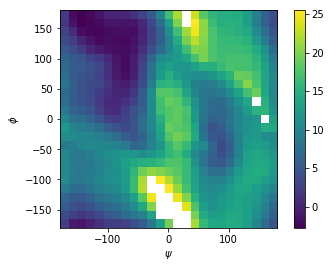

In [34]:
## compute the reduced energy matrix B
l_PMF = 25
L_PMF = l_PMF * l_PMF
psi_PMF = np.linspace(-math.pi, math.pi, l_PMF, endpoint = False)
phi_PMF = np.linspace(-math.pi, math.pi, l_PMF, endpoint = False)
width = 2*math.pi / l_PMF

B = np.zeros((L_PMF, A.shape[1]))

for index in range(L_PMF):
    psi_index = index // l_PMF
    phi_index = index % l_PMF
    psi_c_PMF = psi_PMF[psi_index]
    phi_c_PMF = phi_PMF[phi_index]

    psi_low = psi_c_PMF - 0.5*width
    psi_high = psi_c_PMF + 0.5*width

    phi_low = phi_c_PMF - 0.5*width
    phi_high = phi_c_PMF + 0.5*width

    psi_indicator = ((psi_array > psi_low) & (psi_array <= psi_high)) | \
                     ((psi_array + 2*math.pi > psi_low) & (psi_array + 2*math.pi <= psi_high)) | \
                     ((psi_array - 2*math.pi > psi_low) & (psi_array - 2*math.pi <= psi_high))

    phi_indicator = ((phi_array > phi_low) & (phi_array <= phi_high)) | \
                     ((phi_array + 2*math.pi > phi_low) & (phi_array + 2*math.pi <= phi_high)) | \
                     ((phi_array - 2*math.pi > phi_low) & (phi_array - 2*math.pi <= phi_high))

    indicator = psi_indicator & phi_indicator
    B[index, ~indicator] = np.inf    

## compute PMF using the energy matrix B
PMF, _ = fastmbar.calculate_free_energies_of_perturbed_states(B)

## plot the PMF
fig = plt.figure(0)
fig.clf()
plt.imshow(np.flipud(PMF.reshape((l_PMF, l_PMF)).T), extent = (-180, 180, -180, 180))
plt.xlabel(r"$\psi$")
plt.ylabel(r"$\phi$")
plt.colorbar()
plt.savefig("./output/PMF_fast_mbar.pdf")